In [21]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.window as W
import pyspark.sql.types as T
from pyspark.mllib.stat import KernelDensity
from pyspark.ml.feature import NGram


import unicodedata, string, re, os
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud, STOPWORDS

import pandas as pd
import seaborn as sn
import warnings
import matplotlib.pyplot as plt

import numpy as np
from typing import Literal

warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning
)

In [2]:
MAX_MEMORY = '15G'
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY) \
        .set('spark.jars.packages', "com.datastax.spark:spark-cassandra-connector_2.12:3.3.0") \
        .set('spark.cassandra.connection.host', '127.0.0.1') \
        .set('spark.cassandra.connection.port', '9042') \
        .set('spark.cassandra.output.consistency.level','ONE')

In [3]:
spark = SparkSession \
        .builder \
        .appName("Analysis") \
        .config(conf=conf) \
        .getOrCreate()

23/06/20 16:43:47 WARN Utils: Your hostname, vm-dbudnikov resolves to a loopback address: 127.0.1.1; using 10.151.32.192 instead (on interface ens160)
23/06/20 16:43:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/srv/data/projects/reddit_big_data/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/dbudnikov/.ivy2/cache
The jars for the packages stored in: /home/dbudnikov/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1078ca3b-99ca-4a90-a683-940cf9986d65;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.3.0 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.3.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in cen

In [4]:
df_posts = spark.read. \
        format("org.apache.spark.sql.cassandra"). \
        options(table="posts", keyspace="reddit").load()

In [5]:
df_comments = spark.read. \
        format("org.apache.spark.sql.cassandra"). \
        options(table="comments", keyspace="reddit").load()

In [6]:
df_posts.printSchema()

root
 |-- subreddit: string (nullable = false)
 |-- api_timestamp: timestamp (nullable = true)
 |-- author: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- score: integer (nullable = true)
 |-- selftext: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- uuid: string (nullable = true)



In [7]:
df_comments.printSchema()

root
 |-- subreddit: string (nullable = false)
 |-- api_timestamp: timestamp (nullable = true)
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- downvotes: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- permalink: string (nullable = true)
 |-- submission_id: string (nullable = true)
 |-- upvotes: integer (nullable = true)
 |-- uuid: string (nullable = true)



In [8]:
pd.DataFrame(df_posts.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,subreddit,string
1,api_timestamp,timestamp
2,author,string
3,id,string
4,name,string
5,num_comments,int
6,over_18,boolean
7,score,int
8,selftext,string
9,title,string


In [9]:
pd.DataFrame(df_comments.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,subreddit,string
1,api_timestamp,timestamp
2,author,string
3,body,string
4,downvotes,int
5,id,string
6,name,string
7,over_18,boolean
8,permalink,string
9,submission_id,string


# Visual analysis

In [18]:
def num_posts_distribution(df: "pyspark.sql.dataframe.DataFrame") -> None:
    sn.barplot(df_posts.groupBy(F.col("subreddit")). \
        count(). \
        sort(F.desc("count")). \
        toPandas(),
        y="subreddit", x="count", orient="h"
    )

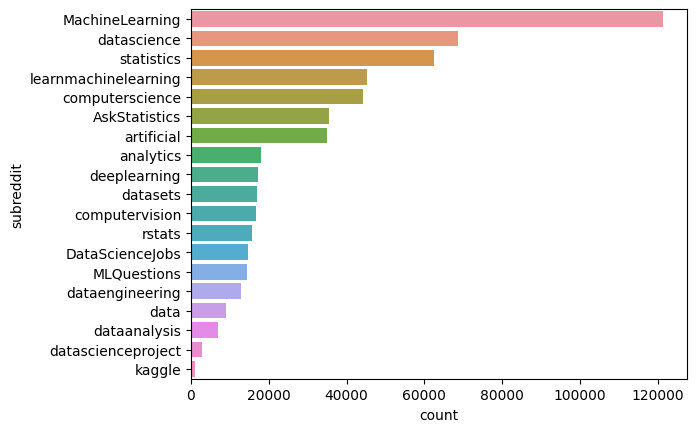

In [19]:
num_posts_distribution(df_posts)

In [27]:
def num_posts_distribution_time_period(
        df: "pyspark.sql.dataframe.DataFrame", 
        period: Literal["year", "month", "day_week", "day_month", "hour"]) -> None:
    
    f_map = {
        "year": F.year,
        "month": F.month,
        "day_month": F.dayofmonth,
        "day_week": F.dayofweek,
        "hour": F.hour,
    }
    plt.xticks(rotation=90)
    sn.barplot(
        df.groupBy(f_map[period](F.col("api_timestamp")).alias(period)).count().toPandas(),
        y="count", x=period
    )

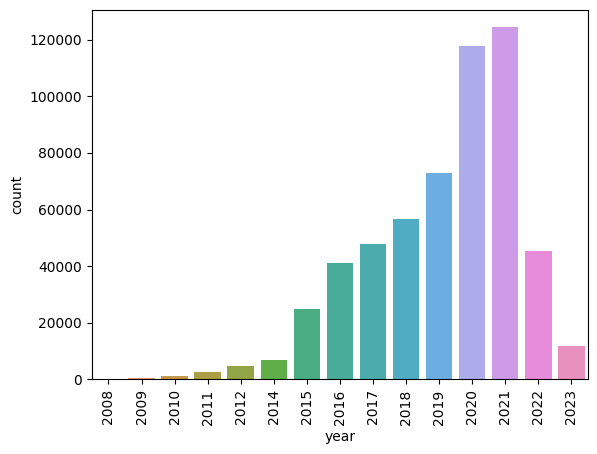

In [28]:
num_posts_distribution_time_period(df_posts, "year")

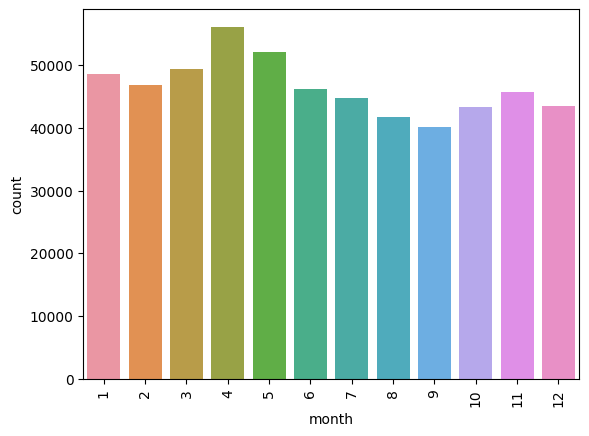

In [29]:
num_posts_distribution_time_period(df_posts, "month")

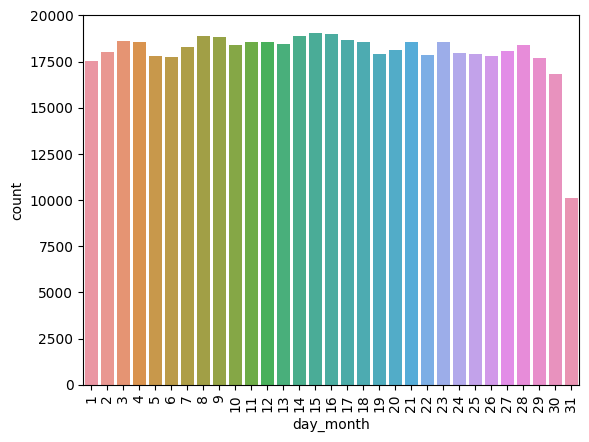

In [30]:
num_posts_distribution_time_period(df_posts, "day_month")

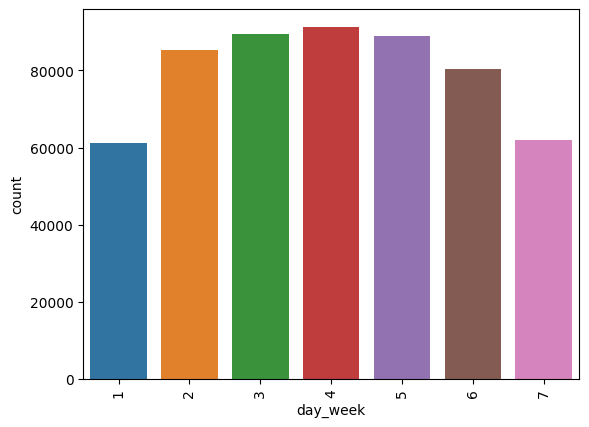

In [32]:
num_posts_distribution_time_period(df_posts, "day_week")

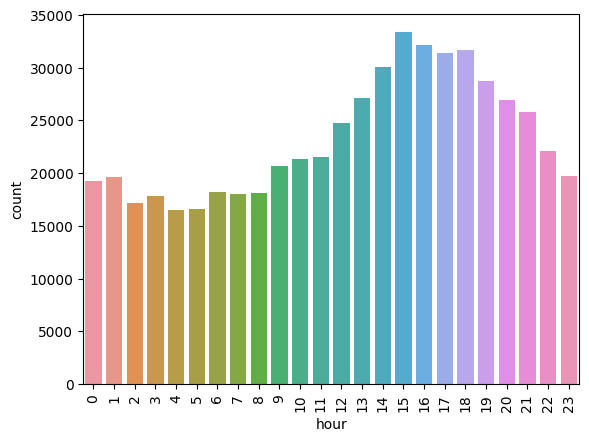

In [33]:
num_posts_distribution_time_period(df_posts, "hour")

In [37]:
def param_density(df: "pyspark.sql.dataframe.DataFrame", param: str) -> None:
    data_rdd = df.select(F.col(param).astype("float")).rdd
    dat_rdd_data = data_rdd.map(lambda x: x[0])

    kd = KernelDensity()
    kd.setSample(dat_rdd_data)
    kd.setBandwidth(0.4)
    points = kd.estimate(np.arange(-2, 100, 0.1, dtype=np.float64))

    sn.lineplot(x=np.arange(-2, 100, 0.1), y=points)
    plt.grid()
    plt.xlabel(param)
    plt.ylabel("Density")
    plt.fill_between(np.arange(-2, 100, 0.1), points)

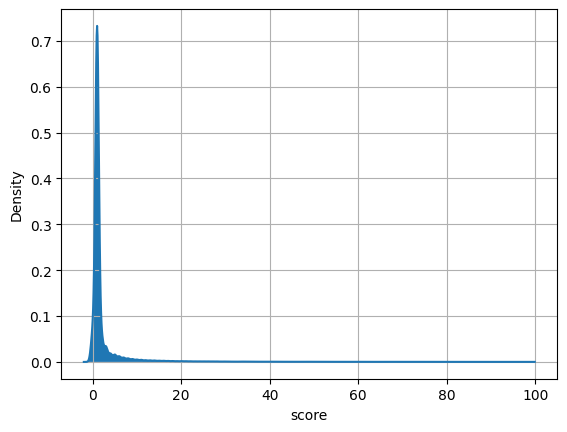

In [38]:
param_density(df_posts, "score")

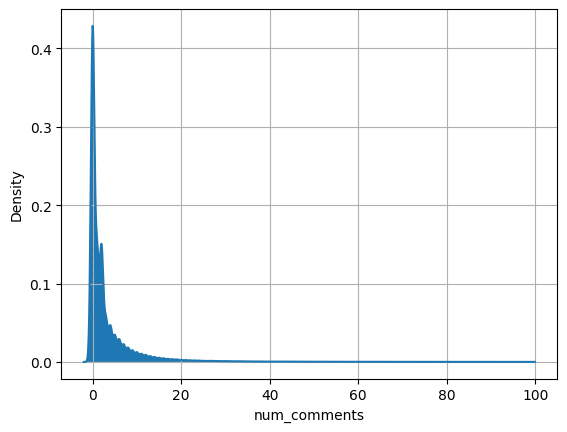

In [39]:
param_density(df_posts, "num_comments")

In [40]:
def pair_distribution(df: "pyspark.sql.dataframe.DataFrame", param1: str, param2: str) -> None:
    df = df.select(F.col(param1), F.col(param2)).toPandas()

    plt.title('Posts score and comments', size = 15)
    plt.grid()
    sn.scatterplot(x = df[param1], y = df[param2],
                    color = '#ff4501', alpha = .8, legend = None)
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.show()

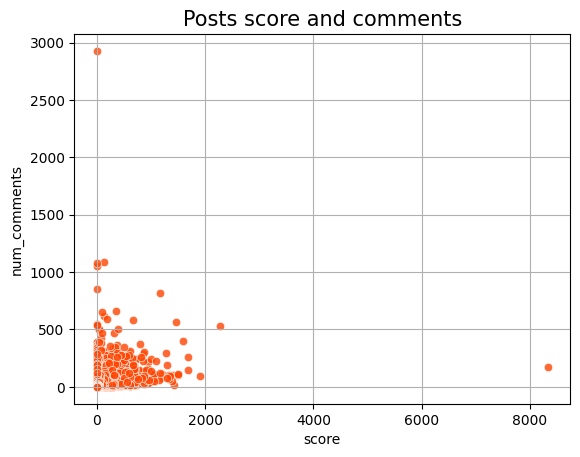

In [41]:
pair_distribution(df_posts, "score", "num_comments")

# Text analysis

In [14]:
def text_clean(df: "pyspark.sql.dataframe.DataFrame", text_col: str) -> "pyspark.sql.dataframe.DataFrame":
   
    
    mod_df = df.na.drop(subset=[text_col]).select(F.col("subreddit"), F.col("api_timestamp"), F.col(text_col))
    
    @F.udf(returnType=T.StringType())
    def clean(text):
        text = text.lower()
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        text = re.sub('\[.*?\]', ' ', text)
        text = re.sub('https?://\S+|www\.\S+', '', text)
        text = re.sub('<.*?>+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', ' ', text)
        text = re.sub('\r', '', text)
        text = re.sub('\w*\d\w*', '', text)

        return text
    
    mod_df = mod_df.select(F.col("subreddit"), F.col("api_timestamp"), clean(F.col(text_col)).alias('clean_text'))
    return mod_df

In [195]:
def text_length(df: "pyspark.sql.dataframe.DataFrame", text_col: str) -> "pyspark.sql.dataframe.DataFrame":
    mod_df = text_clean(df, text_col)
    pdf = mod_df.select(F.length(F.col("clean_text")).alias('text_length')).toPandas()
    plt.title(f"{text_col} length distribution")
    sn.histplot(pdf)

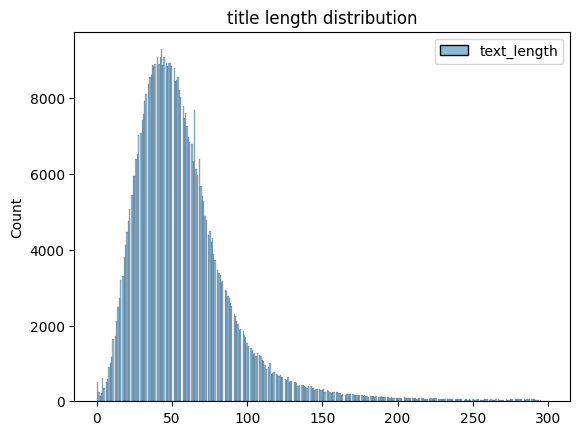

In [196]:
text_length(df_posts, "title")

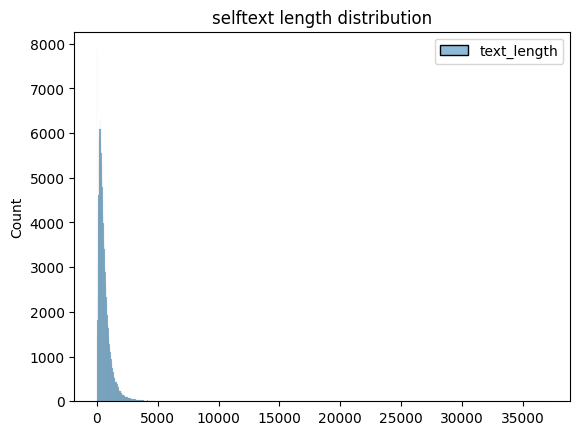

In [197]:
text_length(df_posts, "selftext")

In [78]:
def top_words_analysis(df: "pyspark.sql.dataframe.DataFrame", text_col: str) -> "pyspark.sql.dataframe.DataFrame":
    mod_df = text_clean(df, text_col)
    agg_data = mod_df.select(F.explode(F.split("clean_text", " ")). \
                            alias("word")). \
                            groupBy("word"). \
                            count(). \
                            sort(F.col("count").desc()).limit(10)
    return agg_data

In [79]:
#we need to delete stop wordd
top_words_analysis(df_posts, "title").show()

+----+------+
|word| count|
+----+------+
|    |365379|
|  to|143899|
|   a|127118|
| for|112112|
| the|108965|
|  in|103293|
|data| 96816|
|  of| 92452|
| and| 87672|
|with| 59621|
+----+------+



In [120]:
def top_remove_stop_words(df: "pyspark.sql.dataframe.DataFrame", text_col: str) -> "pyspark.sql.dataframe.DataFrame":
    mod_df = text_clean(df, text_col)
    nltk.download('stopwords')
    stopword = spark.sparkContext.broadcast(set(stopwords.words('english')))
    all_words = mod_df.select(F.explode(F.split("clean_text", " ")).alias("word"))
    filtered_words = all_words.rdd.filter(lambda x: x.word not in stopword.value and x.word != "").toDF()

    agg_data = filtered_words.groupBy("word"). \
                            count(). \
                            sort(F.col("count").desc())
    return agg_data
    

In [123]:
count_vector = top_remove_stop_words(df_posts, "title")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dbudnikov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: title={'center': 'TOP-15 title words'}, xlabel='count', ylabel='word'>

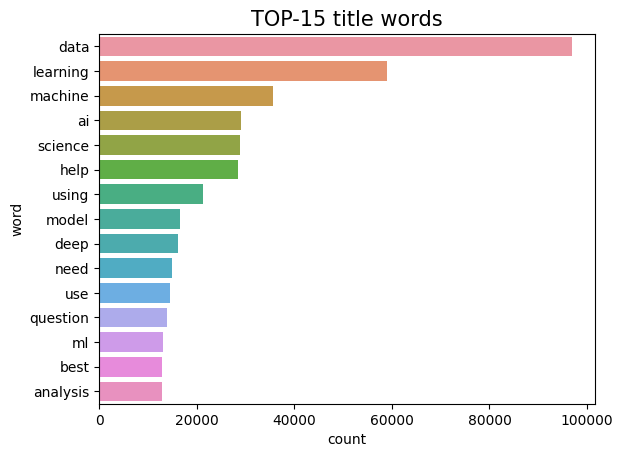

In [198]:
df_to_plot = count_vector.limit(15).toPandas()

plt.title('TOP-15 title words', size = 15)
sn.barplot(y = df_to_plot["word"], x = df_to_plot["count"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dbudnikov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: title={'center': 'TOP-15 words in selftext'}, xlabel='count', ylabel='word'>

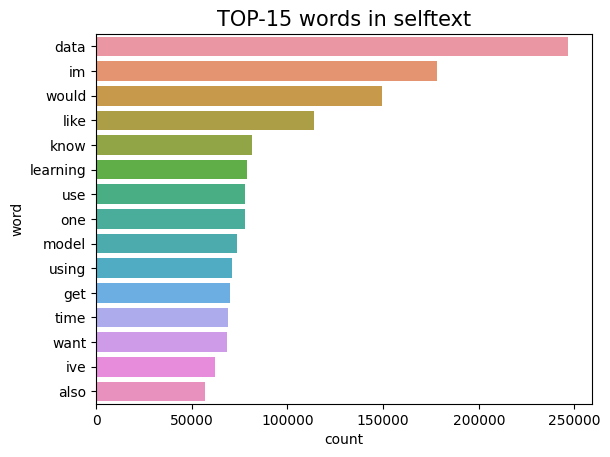

In [201]:
df_to_plot = top_remove_stop_words(df_posts, "selftext").limit(15).toPandas()

plt.title('TOP-15 words in selftext', size = 15)
sn.barplot(y = df_to_plot["word"], x = df_to_plot["count"])

In [182]:
def ngram_counter(df: "pyspark.sql.dataframe.DataFrame", text_col: str, n: int = 2) -> "pyspark.sql.dataframe.DataFrame":
    mod_df = text_clean(df, text_col)
    nltk.download('stopwords')
    stopword = spark.sparkContext.broadcast(set(stopwords.words('english')))

    @F.udf(returnType=T.StringType())
    def remove_stop_words(text):
         return ' '.join(c for c in text.split(" ") if c not in stopword.value)
    
    titles = mod_df.select(remove_stop_words(F.col("clean_text")).alias("clean_text")).rdd
    sentences = titles.map(lambda line: [line.clean_text.split()]) 
    sentences_df = sentences.toDF(schema=["words"])  

    ngram_df = NGram(n=n, inputCol="words", outputCol="bigrams").transform(sentences_df)
    res = ngram_df.select(F.explode("bigrams").alias("bigram")).groupBy("bigram").count().sort(F.col("count").desc())
    return res
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dbudnikov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: title={'center': 'TOP-15 bigrams'}, xlabel='count', ylabel='bigram'>

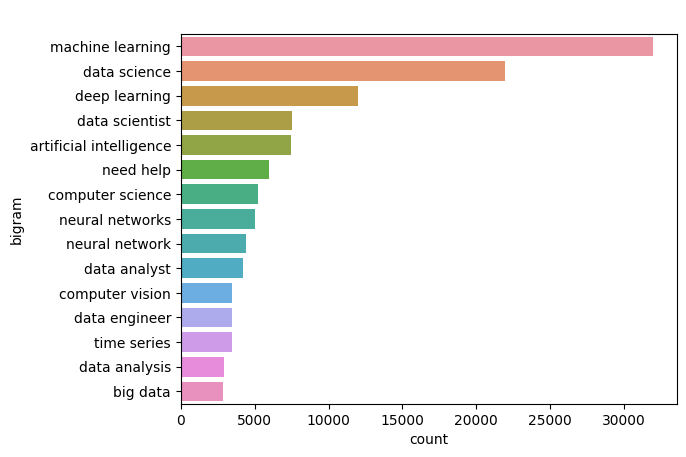

In [188]:
df_to_plot = ngram_counter(df_posts, "title").limit(15).toPandas()

plt.title('TOP-15 bigrams', color = 'white', size = 15)
sn.barplot(y = df_to_plot["bigram"], x = df_to_plot["count"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dbudnikov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: title={'center': 'TOP-15 words in selftext'}, xlabel='count', ylabel='bigram'>

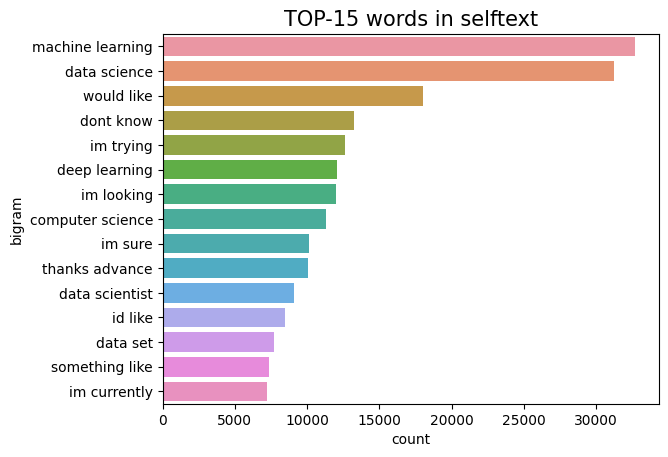

In [203]:
df_to_plot = ngram_counter(df_posts, "selftext").limit(15).toPandas()

plt.title('TOP-15 words in selftext', size = 15)
sn.barplot(y = df_to_plot["bigram"], x = df_to_plot["count"])

# Sentiment analysis

In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [34]:
def sentiment_analysis(df: "pyspark.sql.dataframe.DataFrame", text_col: str) -> "pyspark.sql.dataframe.DataFrame":
     mod_df = text_clean(df, text_col)
     nltk.download('stopwords')
     nltk.download('vader_lexicon')
     stopword = spark.sparkContext.broadcast(set(stopwords.words('english')))

     @F.udf(returnType=T.StringType())
     def remove_stop_words(text):
         return ' '.join(c for c in text.split(" ") if c not in stopword.value)

     @F.udf(returnType=T.FloatType())
     def sentiment_score(text):
          analyzer = SentimentIntensityAnalyzer()
          sentiment = analyzer.polarity_scores(text)
          return sentiment['compound']
    
     score = mod_df.select(F.col("subreddit"), F.col("clean_text"), 
                           sentiment_score(remove_stop_words(F.col("clean_text"))). \
                           alias("sentiment_score")). \
                           orderBy(F.col("sentiment_score").asc())
     return score

In [48]:
def sentiment_analysis_by_subreddit(df: "pyspark.sql.dataframe.DataFrame", text_col: str) -> "pyspark.sql.dataframe.DataFrame":
    mod_df = sentiment_analysis(df, text_col)
    agg_data = mod_df.groupBy("subreddit"). \
                            mean("sentiment_score").alias("mean")
    return agg_data
    

In [ ]:
df_to_plot = sentiment_analysis_by_subreddit(df_posts, "title").toPandas()

<Axes: title={'center': 'Sentiment hist'}, xlabel='avg(sentiment_score)', ylabel='subreddit'>

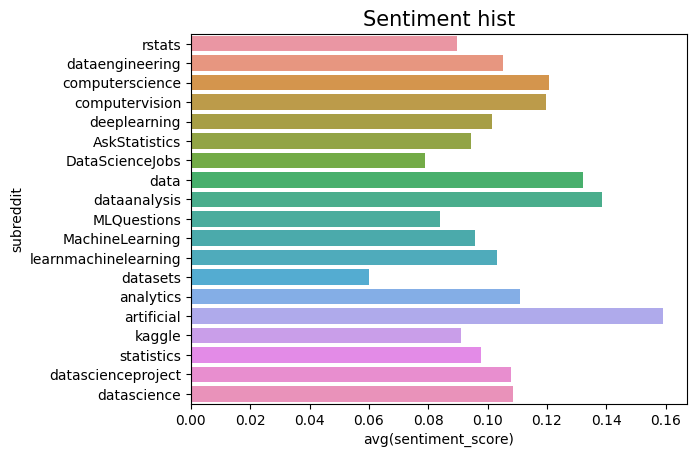

In [54]:
plt.title('Sentiment hist', size = 15)
sn.barplot(x = df_to_plot["avg(sentiment_score)"], y = df_to_plot["subreddit"])

In [35]:
sentiment_title = sentiment_analysis(df_posts, "title").toPandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dbudnikov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dbudnikov/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
sentiment_title["clean_text"].tail()

0    what is this fallacy white people murder white...
1    ds is destroying my mind  i hate math programm...
2    simpsons paradox is observed in  fatality rate...
3    abuse convictions child molestation rape domes...
4    looking for recent data on gun violence and ov...
Name: clean_text, dtype: object

In [10]:
df_posts_scores = spark.read. \
            format("org.apache.spark.sql.cassandra"). \
            options(table="posts_sentiment_score", keyspace="reddit").load()

In [41]:
minutes = lambda i: i * 60

In [44]:
w = (W.Window.partitionBy("subreddit").orderBy(F.col("api_timestamp").cast('long')).rangeBetween(-minutes(10), 0))
df_posts_scores.withColumn('score_rolling_average', F.avg("sentiment_score_title").over(w)).show()

+---------------+-------------------+--------------------+---------------------+---------------------+
|      subreddit|      api_timestamp|            post_uid|sentiment_score_title|score_rolling_average|
+---------------+-------------------+--------------------+---------------------+---------------------+
|computerscience|2008-06-23 15:50:07|c3536424-0dfb-11e...|                  0.0|                  0.0|
|computerscience|2011-01-29 20:41:03|c3536425-0dfb-11e...|                  0.0|                  0.0|
|computerscience|2011-05-12 01:04:57|c3536426-0dfb-11e...|                  0.0|                  0.0|
|computerscience|2011-06-04 19:32:08|c3536427-0dfb-11e...|                  0.0|                  0.0|
|computerscience|2012-05-24 12:45:27|c3536428-0dfb-11e...|                  0.0|                  0.0|
|computerscience|2012-07-06 15:24:55|c3536429-0dfb-11e...|               0.2023| 0.033716666201750435|
|computerscience|2012-07-14 13:51:01|c353642a-0dfb-11e...|              -

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [20]:
df_posts_scores.count()

558535